In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from scipy.spatial import distance
import random
import keras.backend as K
K.set_image_dim_ordering('tf')
img_size = (150, 150, 3)

# %load_ext autoreload
# %autoreload 2
%matplotlib inline

Using Theano backend.
Using gpu device 0: GeForce GTX 1070 (CNMeM is enabled with initial size: 40.0% of memory, cuDNN 5105)



- objects count not correlated with area (objects/background) [TODO]
- randomized shapes? [TODO]
- randomized placement
- no overlaps
- what else?
- random color for objects


In [2]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
#     x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [16]:
# %load circles.py
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import distance
import random
import keras.backend as K
from random import randrange


class GenerateImagesWithObjects:
    def __init__(self,
                 obj_count_range=range(1, 50),
                 obj_size_range=(5, 15),
                 obj_distance_range=(5, 20),
                 distribiuton='uniform',
                 image_shape=(150, 150, 3),
                 edge_dist=20,
                 background='white',
                 area_filling=0.1,
                 black_and_white=False,
                 object_color='random'
                 ):

        self.obj_count_range = obj_count_range
        self.obj_size_range = obj_size_range
        self.obj_distance_range = obj_distance_range
        self.distribiuton = distribiuton
        self.image_shape = image_shape
        self.edge_dist = edge_dist
        self.background = background
        self.black_and_white = black_and_white
        self.color_shape = 3
        self.area_filling = area_filling
        self.object_color = object_color
        if self.black_and_white:
            self.image_shape = self.image_shape[:2]
            self.color_shape = 1

    def _object_color(self):
        if self.object_color == 'random':
            r = np.random.randint(20, 220, size=(self.color_shape), dtype=int)
        else:
            r = (132,) * self.color_shape
        return tuple((int(i) for i in r))

    def _circles_are_distant(self, circle1, circle2):
        x0, y0, r0 = circle1
        x1, y1, r1 = circle2
        dst = distance.euclidean((x0, y0), (x1, y1)) - (r0 + r1)
        return dst > np.random.randint(*self.obj_distance_range)

    def _can_place_circle(self, circles_drawn, new_circle):
        x, y, r = new_circle
        canvas_shape = self.image_shape[1]
        if not all(
                [
                                    0 <= x - r <= canvas_shape,
                                    0 <= x + r <= canvas_shape,
                                    0 <= y - r <= canvas_shape,
                                    0 <= y + r <= canvas_shape
                ]):
            return False  # circle is not overlapping with cnavas edge
        return all([self._circles_are_distant(new_circle, c_on_canvas) for c_on_canvas in circles_drawn])

    def _get_random_circle(self):
        if self.distribiuton == 'uniform':
            x = np.random.randint(self.edge_dist, self.image_shape[0] - self.edge_dist)
            y = np.random.randint(self.edge_dist, self.image_shape[0] - self.edge_dist)
            r = np.random.randint(*self.obj_size_range)
        else:
            raise NotImplementedError

        return x, y, r

    def _generate_n_circle_radiuses_with_same_sum_of_areas(self, n_circles):
        rows, columns = self.image_shape[:2]
        canvas_size = rows * columns
        #         n_circles = np.random.rand(n_circles)
        #         n_circles = np.array([randrange(2, 10)/10.0 for i in range(10)])
        n_circles = np.array([randrange(5, 10) / 10.0 for i in range(n_circles)])

        factor = np.sqrt((canvas_size * self.area_filling / np.pi) / np.sum(n_circles ** 2))
        good_circles_radiuses = n_circles * factor
        print(sum(map(lambda r: np.pi * r ** 2, good_circles_radiuses)))

        return good_circles_radiuses

    def _get_canvas(self):
        if self.background == 'noise':
            canvas = np.random.randint(1, 255, size=self.image_shape, dtype='uint8')
        elif self.background == 'white':
            canvas = np.ones(shape=self.image_shape, dtype='uint8')
        return canvas

    def generate_image(self, nr_objects):

        canvas = self._get_canvas()
        if nr_objects == 0:
            return canvas / 255.0

        circles_drawn = []
        radiuses = self._generate_n_circle_radiuses_with_same_sum_of_areas(nr_objects)
        x = y = r = None
        emergency_counter = 0
        for r in radiuses:
            random_color = self._object_color()
            x, y, _ = self._get_random_circle()
            while not self._can_place_circle(circles_drawn, (x, y, r)):
                x, y, _ = self._get_random_circle()
                emergency_counter += 1
                if emergency_counter > 1000:
                    print('ERROR EMERGENCY EXIT')
                    break
            x, y, r = int(x), int(y), int(r)
            cv2.circle(canvas, (x, y), r, random_color, -1)
            circles_drawn.append((x, y, r))

        return canvas / 255.0

    def image_generator(self, nr_of_objecs_range=range(1, 15), batch_size=32):
        while True:
            batch = []
            ys = []
            for _ in range(batch_size):
                target_y = random.randint(nr_of_objecs_range[0], nr_of_objecs_range[-1])
                batch.append(np.expand_dims(self.generate_image(target_y), 0))
                ys.append(target_y)
            yield (np.concatenate(batch), np.array(ys).reshape(-1, 1))


In [4]:
from keras.layers import Convolution2D, Activation, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.layers import Layer
from keras.optimizers import Adam
from keras.layers import ZeroPadding2D, Dropout
class Round(Layer):

    def __init__(self, **kwargs):
        super(Round, self).__init__(**kwargs)

    def get_output(self, train=False):
        X = self.get_input(train)
        return K.round(X)

    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(Round, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def create_model(image_shape=(150, 150, 1)):
    model = Sequential()
    model.add(Convolution2D(64, 3, 3, input_shape=image_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))

    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))
    
#     model.add(Convolution2D(64, 3, 3))
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))
    
#     model.add(Convolution2D(64, 3, 3))
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(1))
#     model.add(Round())

    return model




from __future__ import print_function
from __future__ import absolute_import

import warnings

from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras.layers import Convolution2D, MaxPooling2D
from keras.engine.topology import get_source_inputs
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras import backend as K






def get_model(input_tensor=None, input_shape=None):

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool1')(x)
    x = Dropout(0.2)(x)
    
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv3')(x)
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool2')(x)
    x = Dropout(0.2)(x)

    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv5')(x)
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv6')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool3')(x)
    x = Dropout(0.2)(x)
    
    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(128, activation='relu', name='fc1')(x)
    x = Dense(1, activation='relu', name='fc2')(x)

    # Ensure that the model takes into account
    # any potential pre3decessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='whatever')

    return model

In [7]:
image_shape = (150, 150)

# model = get_model(input_shape=(150, 150))
model = create_model(image_shape=(150, 150, 1))
# model = VGG_16()
adam = Adam(lr=0.001)
model.compile(
    loss='mean_absolute_percentage_error',
    optimizer=adam,
    metrics=['mean_absolute_percentage_error']
)


In [27]:
go = GenerateImagesWithObjects(background='white', object_color='skls', edge_dist=1, image_shape=(150, 150, 1), black_and_white=True)
ig = go.image_generator(batch_size=64)
# history_model = model.fit_generator(ig, 648, nb_epoch=50)

# # # plt.imshow((go.generate_image(3)))
# im = go.generate_image(10)
# np.expand_dims(im, 3).shape
# a = ig.next()

a = ig.next()
np.expand_dims(a[0], 3).shape

2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0
2250.0


(64, 150, 150, 1)

In [322]:
# go = GenerateImagesWithObjects()
# g = go.image_generator()
# # x, y = g.next()

# model.predict(np.expand_dims(go.generate_image(30), 0))

# model.save_weights('model_weights.kers')

# model = get_model(input_tensor=Input(batch_shape=(1,) + img_size))

# model.load_weights('model_weights.kers')

In [6]:
# from keras.models import load_model

# model = load_model('model_dump.keras')


layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_dict

{'block1_conv1': <keras.layers.convolutional.Convolution2D at 0x7f999543f250>,
 'block1_conv2': <keras.layers.convolutional.Convolution2D at 0x7f9995134c90>,
 'block1_conv3': <keras.layers.convolutional.Convolution2D at 0x7f9994ddb9d0>,
 'block1_conv4': <keras.layers.convolutional.Convolution2D at 0x7f9994de3d10>,
 'block1_conv5': <keras.layers.convolutional.Convolution2D at 0x7f9994d57190>,
 'block1_conv6': <keras.layers.convolutional.Convolution2D at 0x7f9994d199d0>,
 'block1_pool1': <keras.layers.pooling.MaxPooling2D at 0x7f99950e8fd0>,
 'block1_pool2': <keras.layers.pooling.MaxPooling2D at 0x7f9994d4cb50>,
 'block1_pool3': <keras.layers.pooling.MaxPooling2D at 0x7f9994cce050>,
 'dropout_1': <keras.layers.core.Dropout at 0x7f9995099b90>,
 'dropout_2': <keras.layers.core.Dropout at 0x7f9994da9c90>,
 'dropout_3': <keras.layers.core.Dropout at 0x7f9994cce890>,
 'fc1': <keras.layers.core.Dense at 0x7f9994cd2290>,
 'fc2': <keras.layers.core.Dense at 0x7f9994c71b10>,
 'flatten': <keras.la

In [11]:
# from scipy.misc import imsave
# from copy import deepcopy

# for i in range(0,10):
#     print(i)

#     layer_name = 'block1_conv1'
#     filter_index = i
#     layer_output = layer_dict[layer_name].output

#     first_layer = model.layers[0]
#     input_img = first_layer.input

#     loss = K.mean(layer_output[:,:,:,filter_index])
#     grads = K.gradients(loss, input_img)[0]
#     grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
#     iterate = K.function([input_img], [loss, grads])
# #     iterate = K.function([input_img, K.learning_phase()], [loss, grads])
#     input_img_data = np.random.random((1,150, 150,3)) 

#     for i in range(200):
# #         loss_value, grads_value = iterate([input_img_data, 0])
#         loss_value, grads_value = iterate([input_img_data])

#     #     print(loss_value, grads_value)
#         input_img_data += grads_value * 1.
        
#     plt.figure()
#     plt.imshow(input_img_data[0])
 
    
    
input_img = model.layers[0].input
import time    
img_width, img_height = 150, 150   
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


layer_name = 'block1_conv6'

kept_filters = []
for filter_index in range(0, 66):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_dim_ordering() == 'th':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img, K.learning_phase()], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_dim_ordering() == 'th':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
#     input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(200):
        loss_value, grads_value = iterate([input_img_data, 1])
        input_img_data += grads_value * step

#         print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))


Processing filter 0
Filter 0 processed in 2s
Processing filter 1
Filter 1 processed in 2s
Processing filter 2
Filter 2 processed in 1s
Processing filter 3
Filter 3 processed in 2s
Processing filter 4
Filter 4 processed in 2s
Processing filter 5
Filter 5 processed in 2s
Processing filter 6
Filter 6 processed in 2s
Processing filter 7
Filter 7 processed in 2s
Processing filter 8
Filter 8 processed in 2s
Processing filter 9
Filter 9 processed in 1s
Processing filter 10
Filter 10 processed in 2s
Processing filter 11
Filter 11 processed in 1s
Processing filter 12
Filter 12 processed in 2s
Processing filter 13
Filter 13 processed in 2s
Processing filter 14
Filter 14 processed in 2s
Processing filter 15
Filter 15 processed in 1s
Processing filter 16
Filter 16 processed in 2s
Processing filter 17
Filter 17 processed in 1s
Processing filter 18
Filter 18 processed in 1s
Processing filter 19
Filter 19 processed in 2s
Processing filter 20
Filter 20 processed in 2s
Processing filter 21
Filter 21 pr

IndexError: index out of bounds
Apply node that caused the error: GpuIncSubtensor{InplaceInc;::, ::, ::, int64}(GpuAlloc{memset_0=True}.0, GpuElemwise{Composite{((inv(i0) / i1) / i2)},no_inplace}.0, Constant{64})
Toposort index: 148
Inputs types: [CudaNdarrayType(float32, 4D), CudaNdarrayType(float32, (True, True, True)), Scalar(int64)]
Inputs shapes: [(1, 37, 37, 64), (1, 1, 1), ()]
Inputs strides: [(0, 2368, 64, 1), (0, 0, 0), ()]
Inputs values: ['not shown', CudaNdarray([[[ 0.00073046]]]), 64]
Outputs clients: [[GpuDimShuffle{0,3,1,2}(GpuIncSubtensor{InplaceInc;::, ::, ::, int64}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

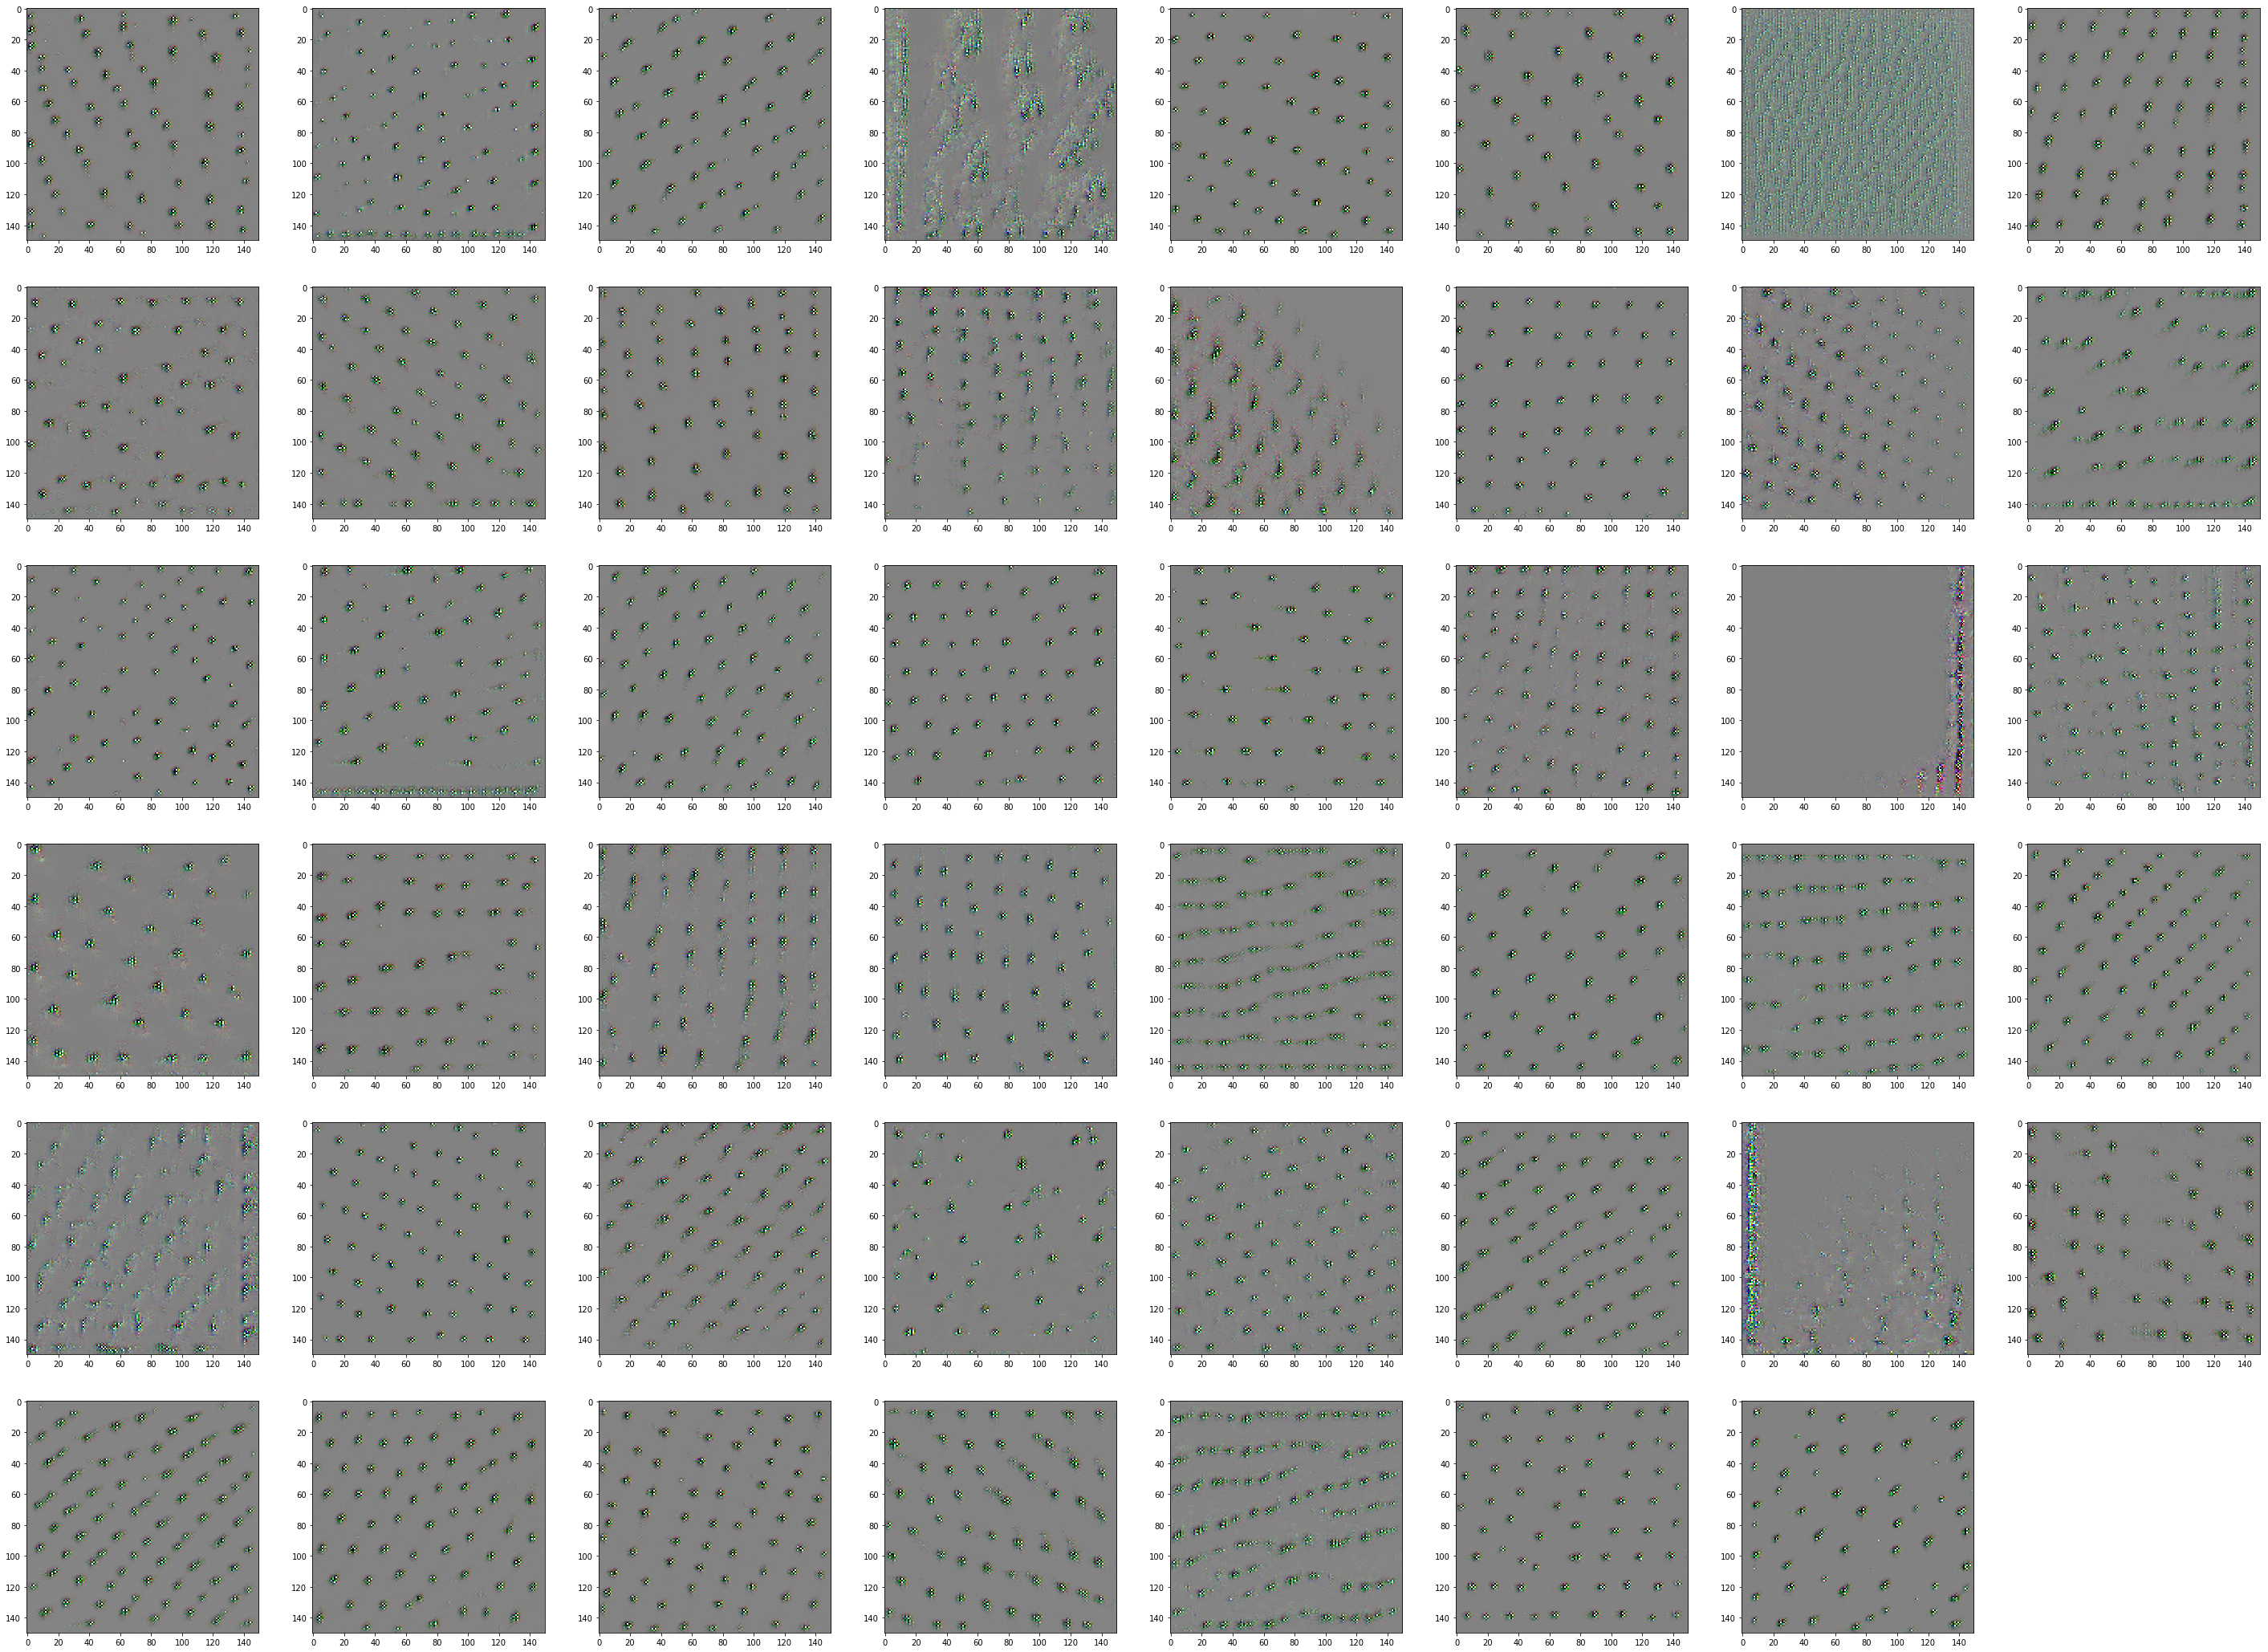

In [12]:
plt.figure(figsize=(50,50))

for i, v in enumerate(kept_filters):
    plt.subplot(8,8,i+1)
    plt.imshow(v[0])
plt.savefig('cnn6_onecolor.png')

In [225]:
model.layers[0].output[:, 1,:,:]

Subtensor{::, int64, ::, ::}.0

In [22]:
import sys
from keras.layers import Input
from keras.models import load_model


# model = load_model('bla.keras')

sys.path.append('/home/i008/googledrive/Projects/art_it_up')
from filter_object_mapping import MaxActivatingImage

img_size = (150, 150, 3)
input_tensor = Input(batch_shape=(1,) + img_size)

In [33]:
mai = MaxActivatingImage(model, model.input, layer_nr=5, filter_nr=1)

{'x_shape': (1, 75, 75, 64), 'layer_nr': 5, 'clip_edge': 2, 'self': <filter_object_mapping.MaxActivatingImage instance at 0x7fc0cc09a710>, 'filter_nr': 1, 'reg_cont': 0.0001, 'x': <tf.Tensor 'strided_slice_38:0' shape=(1, 75, 75) dtype=float32>, 'model': <keras.engine.training.Model object at 0x7fc0d3f2f990>, 'input_tensor': <tf.Tensor 'input_1:0' shape=(1, 150, 150, 3) dtype=float32>, 'reg_l2': 0.1}
Tensor("Square_24:0", shape=(1, 71, 71), dtype=float32)
Tensor("Sum_18:0", shape=(), dtype=float32)


In [51]:
import utils

print(img_size)
# model.input = input_tensor
# img_canvas = utils.empty_canvas(img_size,color = (128,128,128),normalize = False,plot = True)
tensor_canvas=np.random.random((1,150, 150,3))

im = go.generate_image(4)
# mai.generate_activating_image(im, optim_iterations=20, iterations=300)

(150, 150, 3)


In [32]:
input_tensor

<tf.Tensor 'input_3:0' shape=(1, 150, 150, 3) dtype=float32>

In [39]:
input_tensor.get_shape()

TensorShape([Dimension(1), Dimension(150), Dimension(150), Dimension(3)])

In [26]:
model.layers

In [42]:
jitter = 15
random_jitter = (jitter * 2) * (np.random.random((150,150,3)) - 0.5)

In [45]:
random_jitter

array([[[  1.79227342, -11.55405882,   2.84004924],
        [ -2.91609522,  -8.17845081,  12.88505361],
        [-13.82571616,  -9.59387466,   6.75703149],
        ..., 
        [-14.45156222,  -1.7167447 ,   2.40411454],
        [  1.75722865, -14.8340083 ,  -3.87304789],
        [  0.17783195,  -6.77178559,  10.14721512]],

       [[ 12.0919509 ,   9.08426634,  -6.4318903 ],
        [ -5.57870386, -12.42491452, -13.50709746],
        [  4.82703412,   6.25366304, -14.85499752],
        ..., 
        [  9.29239772,   6.1475053 ,  -3.38538169],
        [ 13.33855934, -12.58267512, -14.37970436],
        [  1.12057841,  -9.9876069 ,  -7.08316275]],

       [[-10.60741584,  -0.14722684,  -0.53672444],
        [ 14.53988768,   7.67629797,   2.42514623],
        [-10.65234625,  -2.14537129,  -8.45470284],
        ..., 
        [ -5.2174533 , -13.58480488,  -6.94039686],
        [ 10.990884  ,   7.88550681,  -6.43084305],
        [  7.94150043, -10.69581578,   5.81627443]],

       ..., 
   

In [50]:
im

array([[[ 0.00392157,  0.00392157,  0.00392157],
        [ 0.00392157,  0.00392157,  0.00392157],
        [ 0.00392157,  0.00392157,  0.00392157],
        ..., 
        [ 0.00392157,  0.00392157,  0.00392157],
        [ 0.00392157,  0.00392157,  0.00392157],
        [ 0.00392157,  0.00392157,  0.00392157]],

       [[ 0.00392157,  0.00392157,  0.00392157],
        [ 0.00392157,  0.00392157,  0.00392157],
        [ 0.00392157,  0.00392157,  0.00392157],
        ..., 
        [ 0.00392157,  0.00392157,  0.00392157],
        [ 0.00392157,  0.00392157,  0.00392157],
        [ 0.00392157,  0.00392157,  0.00392157]],

       [[ 0.00392157,  0.00392157,  0.00392157],
        [ 0.00392157,  0.00392157,  0.00392157],
        [ 0.00392157,  0.00392157,  0.00392157],
        ..., 
        [ 0.00392157,  0.00392157,  0.00392157],
        [ 0.00392157,  0.00392157,  0.00392157],
        [ 0.00392157,  0.00392157,  0.00392157]],

       ..., 
       [[ 0.00392157,  0.00392157,  0.00392157],
        

In [351]:
g = GenerateImagesWithObjects(background='white', object_color='static', edge_dist=0, image_shape=(150, 150,3), black_and_white=True)

g.generate_image(3)

2250.0


TypeError: Layout of the output array img is incompatible with cv::Mat (step[ndims-1] != elemsize or step[1] != elemsize*nchannels)

In [344]:
%matplotlib inline

im = g.generate_image(30)
plt.imshow(im, cmap='gray')

2250.0


TypeError: Layout of the output array img is incompatible with cv::Mat (step[ndims-1] != elemsize or step[1] != elemsize*nchannels)

In [237]:
from random import randrange

n_circles = np.array([randrange(2, 10)/10.0 for i in range(10)])

In [71]:
n_circles.dtype

dtype('float64')

In [72]:
np.random.rand(10).dtype

dtype('float64')

In [195]:
tuple(i for i in range(10))

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

(150, 150)

TypeError: Invalid dimensions for image data

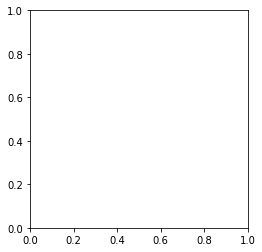

In [337]:
plt.imshow(np.zeros((150, 150, 1)))